<div style="text-align: right"><i>Peter Norvig<br>2012<br>Updated 2020</i></div>

# Poker: Ranking Hands, etc.


The [rules for poker hands](https://en.wikipedia.org/wiki/List_of_poker_hands) are complex, but it is an interesting exercise to write a program to rank poker hands&mdash;to determine if one is higher or lower than another&mdash;as I did in my [Udacity 212](https://www.udacity.com/course/design-of-computer-programs--cs212) course after making a [cheesy video](https://www.youtube.com/watch?v=PI8Fo1vzUPM) with David Evans.  We'll cover only the ranking part of poker, not the betting part. Some key concepts:

- **Card**: A card will be represented as a two character string, like `'9c'`, where the first character is the **rank** and the second is the **suit**. The ranks are `23456789TJQKA` in ascending order of value and the suits are `'cdhs'` for clubs, diamonds, hearts, and spades; all suits have equal value in poker. I thought about using the Unicode characters `'♣︎♢♡♠︎'`, but they are hard to find on the keyboard. I also thought of using `(10, 0)` instead of `'Tc'`; the former might allow for a bit faster code, but the later is easier to look at when debugging.
- **Hand**: A hand is a sequence of five cards: `['3s', '3c', 'As', 'Ks', 'Qs']`
- **Type**: A hand has a ranking **type**; these are (in highest to lowest order): five of a kind, straight flush, four of a kind, full house, flush, straight, three of a kind, two pair, one pair, high card. (Five of a kind can only be made in games with wild cards.)
- **Group**: A collection of cards with the same rank: a pair, a three-of-a-kind, etc.
- **Winning**: If two hands have different types, the higher type wins. If they have the same type, a **tiebreaker** is needed. For example, the tiebreaker for "straight" is the rank of the highest card; a ten-high straight beats a nine-high straight.
- **Ranking**: To determine who wins, we assign a **ranking** to each hand; the ranking encompasses the type and tiebreaker. The winner is the hand with the highest ranking. Note that the word **ranking** refers to the value of a *hand*, but **rank** refers to the value of a *card*.

# Ranking and Integer Partitions

There is a curious correspondence between the seven types of poker hands that involve groups and the seven **[integer partitions](https://en.wikipedia.org/wiki/Partition_(number_theory))** of the number 5. 

Consider this table of ranking types:


| Type| # | Example &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|Partitions |
|-|--|---|---|
| Five of a kind |9|`As Ac Ah Ad Aj`| (5,) |
| Straight flush  |8|`As Ks Qs Ts Js`| |
| Four of a kind |7|`7s 7c 7d 2d 7h`|  (4, 1)|
| Full house |6| `8h 9c 8d 8c 9h`|     (3, 2)|
| Flush |5| `8c Kc Qc Jc Tc`|          |
| Straight |4| `Kc Qh Jd Th 9c`|       |
| Three of a kind |3| `Ts Tc Th 9s 7c`| (3, 1, 1)|
| Two pair |2|  `Ts Tc 9s 9c 7h`|       (2, 2, 1)  |
| One pair |1|  `3s 3c As Ks Qs`|          (2, 1, 1, 1)|
| High card |0| `2s 4s 5s 6s 7h`|         (1, 1, 1, 1, 1)|

The types are sorted from highest to lowest, and the partitions are also sorted in lexicographic order from highest to lowest. The correspondence is that, for example, `(3, 2)` means "three cards of one rank and two cards of another rank", which is the definition of a full house. 

Let's get some preliminaries out of the way so we can start to program a solution for ranking.

In [1]:
import random
import matplotlib.pyplot as plt
from collections import Counter
from statistics  import mean
from itertools   import combinations, permutations, product
from functools   import lru_cache

In [2]:
# Data Types
Card = str              # A card is a str of length 2: '7s'
Hand = (list, tuple)    # A hand is 5 cards in either a list or a tuple

# Functions and Objects
join    = ' '.join        # Function to join cards together into one string
cards   = str.split       # Function to split a string apart into a list of cards
rankstr = '23456789TJQKA' # Card ranks in ascending order

def rank(card) -> int: return rankstr.index(card[0]) + 2
def suit(card) -> str: return card[1]

A `collections.Counter` does most of the work of finding  groups and thus partitions. It tells us that the following full house has three 8s and two 9s:

In [3]:
hand = cards('8h 9c 8d 8c 9h')

Counter(map(rank, hand))

Counter({8: 3, 9: 2})

This gives us all the information we need; the problem is that it is not in the right format to compare rankings. We can't  do `counter1 < counter2` because Counters do not support comparison. But we can reformat the information into a tuple consisting of two components: 
 1. The **type** of hand, full house, which is denoted by the partition `(3, 2)`.
 2. The **tiebreakers**: among all full houses, ties go to the highest three-of-a-kind card, and if those are the same, then the highest pair card. So the tiebreaker for this hand would be `(8, 9)`. (Even though 9 > 8, the 8 comes first because the three-of-a-kind is more important than the pair.)

Thus the complete ranking for this hand is the tuple `((3, 2), (8, 9))`. The same information as in the Counter, but in the proper order for sorting.

So (ignoring straights and flushes for now) here's how we do  `ranking`:

In [4]:
def ranking(hand) -> tuple:
    """Return a (type, tiebreaker) tuple indicating how high the hand ranks."""
    counts = Counter(map(rank, hand))
    groups = sorted(((counts[r], r) for r in counts), reverse=True)
    return tuple(zip(*groups))

Here is the process step by step:

In [5]:
counts = Counter(map(rank, hand))
counts

Counter({8: 3, 9: 2})

In [6]:
groups = sorted(((counts[r], r) for r in counts), reverse=True)
groups

[(3, 8), (2, 9)]

In [7]:
tuple(zip(*groups))

((3, 2), (8, 9))

Notice that this final result is the **matrix transpose** (switching rows and columns) of  `groups`. In Python the transpose of `m` is `zip(*m)`.

Below we see that the eights-over-nines full house beats a six-over-tens full house (it doesn't matter that 10 > 9; what matters is 8 > 6):

In [8]:
hand2 = cards('6h 6c 6d Tc Th')

In [9]:
ranking(hand)

((3, 2), (8, 9))

In [10]:
ranking(hand2)

((3, 2), (6, 10))

In [11]:
ranking(hand) > ranking(hand2)

True

# Ranking Straights and Flushes

It is a cute mathematical result that poker rankings correspond to the integer partitions of 5, but the correspondence does not account for straights and flushes. Still, we can salvage the approach by inventing "type tuples" for straight, flush, and straight flush that are not partitions but are in the correct sort order with respect to the seven actual partitions. There are many possible choices; my choices, shown in **bold** below, are to look at the type one row below and add 1 to the last digit: one better than `(3, 1, 1)` is `(3, 1, 2)`; one better than `(4, 1)` is `(4, 2)`.


| Type| # | Example &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|Type tuple |
|-|--|---|---|
| Five of a kind |9|`As Ac Ah Ad Aj`| (5,) |
| Straight flush  |8|`As Ks Qs Ts Js`| **(4, 2)**|
| Four of a kind |7|`7s 7c 7d 2d 7h`|  (4, 1)|
| Full house |6| `8h 9c 8d 8c 9h`|     (3, 2)|
| Flush |5| `8c Kc Qc Jc Tc`|  **(3, 1, 3)**        |
| Straight |4| `Kc Qh Jd Th 9c`| **(3, 1, 2)**      |
| Three of a kind |3| `Ts Tc Th 9s 7c`| (3, 1, 1)|
| Two pair |2|  `Ts Tc 9s 9c 7h`|       (2, 2, 1)  |
| One pair |1|  `3s 3c As Ks Qs`|          (2, 1, 1, 1)|
| High card |0| `2s 4s 5s 6s 7h`|         (1, 1, 1, 1, 1)|

It is easy to code this up; the function `special_type` handles  flushes and straights, and `rankings` uses the special type or the regular type. Another complication is that in poker aces are not always high: If we have a 5-4-3-2-A hand, the ace serves as a `1` rather than a `14`; we adjust `ranks` accordingly in `rankings`. To test for a flush, we look at the collection of suits and ask if they are all `the_same`.

In [12]:
def ranking(hand) -> tuple:
    """Return a value indicating how high the hand ranks."""
    counts = Counter(map(rank, hand))
    groups = sorted(((counts[r], r) for r in counts), reverse=True)
    type, ranks = zip(*groups)
    if ranks == (14, 5, 4, 3, 2):
        ranks = (5, 4, 3, 2, 1)
    return special_type(hand, ranks) or type, ranks

def special_type(hand, ranks) -> tuple:
    """For a flush or straight, return a tuple comparable with `type` in `ranking`."""
    straight = len(ranks) == 5 and max(ranks) - min(ranks) == 4
    flush    = the_same(map(suit, hand))
    return ((4, 2)    if straight and flush else 
            (3, 1, 3) if flush else 
            (3, 1, 2) if straight else ())

def the_same(things) -> bool: return len(set(things)) <= 1

# Testing Poker Hands

Below is a list of `hands`, with four examples of each **type**, all in descending ranking order (i.e. best to worst).  The `test` function asserts that (1) the `ranking` function agrees with this ordering; (2) the order of cards within a hand does not matter&mdash;every permutation of cards is ranked the same; and (3) swapping the suits around (e.g. swapping every spade with every club) does not change the ranking.

In [13]:
hands = [cards(h) for h in (           
    'As Ac Ah Ad Ad', 'Kh Kd Ks Kc Kh', '3h 3s 3d 3c 3c', '2s 2c 2d 2h 2h', # 5 of a kind     
    'As Ks Qs Ts Js', 'Kc Qc Jc Tc 9c', '6d 5d 4d 3d 2d', '5h 4h 3h 2h Ah', # straight flush  
    'As Ac Ad Ah 2s', '7s 7c 7d 2d 7h', '6s 6c 6d 6h 9s', 'As 5h 5c 5d 5s', # four of a kind 
    'Th Tc Td 5h 5c', '9h 9c 9d 8c 8h', '6h 6c 6d Tc Th', '5c 5d 5s As Ah', # full house
    'As 2s 3s 4s 6s', 'Kc Qc Jc Tc 2c', 'Qc Jc Tc 9c 7c', '4h 5h 6h 7h 9h', # flush
    'As Kd Qc Td Jh', 'Kc Qh Jd Th 9c', '6c 5d 4h 3s 2s', 'As 2d 3c 4h 5s', # straight
    'As Ac Ad 2h 3h', 'Ts Tc Th 9s 8c', 'Ts Tc Th 9s 7c', '9h 9s 9d Ah Kh', # three of a kind
    'Ts Tc 5s 5c 8h', 'Ts Tc 5s 5c 7h', '9s 9c 8s 8c As', '3s 3c 2s 2d Ah', # two pair 
    'As Ac 4c 5s 6s', '4s 4c As Ks Qs', '4h 4d Kh Qd Jd', '2d 2c Ad Kd Qd', # pair 
    'Ah 3s 4s 5s 6s', 'Kh Qh Jh Th 8d', '7d 2s 4s 5s 6s', '7h 6s 5d 3s 2d', # high card
         )]

def test(ranking, hands=hands) -> bool:
    """Test that `ranking` preserves order of `hands`, and that permuting cards is irrelevant."""
    assert hands == sorted(hands, key=ranking, reverse=True)
    trans = str.maketrans('shdc', 'cdhs')
    for hand in hands: 
        assert the_same(ranking(h) for h in permutations(hand))
        assert the_same([ranking(hand), ranking([c.translate(trans) for c in hand])])
    return len(hands)

In [14]:
test(ranking)

40

Let's see what rankings look like:

In [15]:
{join(h): ranking(h) for h in hands}

{'As Ac Ah Ad Ad': ((5,), (14,)),
 'Kh Kd Ks Kc Kh': ((5,), (13,)),
 '3h 3s 3d 3c 3c': ((5,), (3,)),
 '2s 2c 2d 2h 2h': ((5,), (2,)),
 'As Ks Qs Ts Js': ((4, 2), (14, 13, 12, 11, 10)),
 'Kc Qc Jc Tc 9c': ((4, 2), (13, 12, 11, 10, 9)),
 '6d 5d 4d 3d 2d': ((4, 2), (6, 5, 4, 3, 2)),
 '5h 4h 3h 2h Ah': ((4, 2), (5, 4, 3, 2, 1)),
 'As Ac Ad Ah 2s': ((4, 1), (14, 2)),
 '7s 7c 7d 2d 7h': ((4, 1), (7, 2)),
 '6s 6c 6d 6h 9s': ((4, 1), (6, 9)),
 'As 5h 5c 5d 5s': ((4, 1), (5, 14)),
 'Th Tc Td 5h 5c': ((3, 2), (10, 5)),
 '9h 9c 9d 8c 8h': ((3, 2), (9, 8)),
 '6h 6c 6d Tc Th': ((3, 2), (6, 10)),
 '5c 5d 5s As Ah': ((3, 2), (5, 14)),
 'As 2s 3s 4s 6s': ((3, 1, 3), (14, 6, 4, 3, 2)),
 'Kc Qc Jc Tc 2c': ((3, 1, 3), (13, 12, 11, 10, 2)),
 'Qc Jc Tc 9c 7c': ((3, 1, 3), (12, 11, 10, 9, 7)),
 '4h 5h 6h 7h 9h': ((3, 1, 3), (9, 7, 6, 5, 4)),
 'As Kd Qc Td Jh': ((3, 1, 2), (14, 13, 12, 11, 10)),
 'Kc Qh Jd Th 9c': ((3, 1, 2), (13, 12, 11, 10, 9)),
 '6c 5d 4h 3s 2s': ((3, 1, 2), (6, 5, 4, 3, 2)),
 'As 2d 3c 4

# Alternative Definition: `ranking2`

If you think dealing with integer partitions of 5 was a little too abstract, and/or that fabricating `(3, 1, 3)` as the type for a flush was a little too *ad hoc*, then here's an alternative ranking function, `ranking2`, that you might find more straightforward. Instead of type tuples, it uses the integers 9 to 0 for types, and then does tiebreakers in the same way as `ranking`.

The one tricky part is the use of `kinds/kind`: for a two-pair hand `8h 9c 8d 9d 4h`, `kinds` will be the list `[[], [4], [9, 8], [], [], []]`, and `kinds[2]` is `[9, 8]` (meaning: what ranks have 2 of a kind? 9 and 8, with the highest rank always first), and `kind(1)` is `4` (meaning: what rank has one of a kind? 4). 

In [16]:
def ranking2(hand) -> tuple:
    """Return a value indicating how high the hand ranks."""
    ranks = sorted(map(rank, hand), reverse=True)
    if ranks == [14, 5, 4, 3, 2]:
        ranks = [5, 4, 3, 2, 1]
    straight = len(set(ranks)) == 5 and max(ranks) - min(ranks) == 4
    flush    = the_same(map(suit, hand))
    kinds    = [[] for n in range(6)]
    kind     = lambda n: kinds[n][0]
    for r in sorted(set(ranks), reverse=True):
        kinds[ranks.count(r)].append(r)
    return ((9, max(ranks))         if kinds[5] else
            (8, max(ranks))         if straight and flush else
            (7, kind(4), kind(1))   if kinds[4] else
            (6, kind(3), kind(2))   if kinds[3] and kinds[2] else
            (5, *ranks)             if flush else
            (4, max(ranks))         if straight else
            (3, kind(3), *kinds[1]) if kinds[3] else
            (2, *kinds[2], kind(1)) if len(kinds[2]) == 2 else
            (1, kind(2), *kinds[1]) if kinds[2] else
            (0, *ranks))

`ranking2` passes the tests:

In [17]:
test(ranking2, hands)

40

Here are what the `ranking2` rankings look like&mdash;a little more concise:

In [18]:
{join(h): ranking2(h) for h in hands}

{'As Ac Ah Ad Ad': (9, 14),
 'Kh Kd Ks Kc Kh': (9, 13),
 '3h 3s 3d 3c 3c': (9, 3),
 '2s 2c 2d 2h 2h': (9, 2),
 'As Ks Qs Ts Js': (8, 14),
 'Kc Qc Jc Tc 9c': (8, 13),
 '6d 5d 4d 3d 2d': (8, 6),
 '5h 4h 3h 2h Ah': (8, 5),
 'As Ac Ad Ah 2s': (7, 14, 2),
 '7s 7c 7d 2d 7h': (7, 7, 2),
 '6s 6c 6d 6h 9s': (7, 6, 9),
 'As 5h 5c 5d 5s': (7, 5, 14),
 'Th Tc Td 5h 5c': (6, 10, 5),
 '9h 9c 9d 8c 8h': (6, 9, 8),
 '6h 6c 6d Tc Th': (6, 6, 10),
 '5c 5d 5s As Ah': (6, 5, 14),
 'As 2s 3s 4s 6s': (5, 14, 6, 4, 3, 2),
 'Kc Qc Jc Tc 2c': (5, 13, 12, 11, 10, 2),
 'Qc Jc Tc 9c 7c': (5, 12, 11, 10, 9, 7),
 '4h 5h 6h 7h 9h': (5, 9, 7, 6, 5, 4),
 'As Kd Qc Td Jh': (4, 14),
 'Kc Qh Jd Th 9c': (4, 13),
 '6c 5d 4h 3s 2s': (4, 6),
 'As 2d 3c 4h 5s': (4, 5),
 'As Ac Ad 2h 3h': (3, 14, 3, 2),
 'Ts Tc Th 9s 8c': (3, 10, 9, 8),
 'Ts Tc Th 9s 7c': (3, 10, 9, 7),
 '9h 9s 9d Ah Kh': (3, 9, 14, 13),
 'Ts Tc 5s 5c 8h': (2, 10, 5, 8),
 'Ts Tc 5s 5c 7h': (2, 10, 5, 7),
 '9s 9c 8s 8c As': (2, 9, 8, 14),
 '3s 3c 2s 2d Ah': (2,

# Timing

Below we see that `ranking2` is about 15% faster than `ranking`, so use `ranking2` when speed is important.

In [19]:
%timeit test(ranking,  hands)
%timeit test(ranking2, hands)

31.1 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.1 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Winning

It is tempting to define a function `winner(hands) -> Hand` to see who wins a round, and we will do that, for convenience. But in poker if two hands are exactly the same except for suits, then they tie. So to be more precise we will also define `winners(hand)` to return a *set* of winners (which in most cases will have only one member).

Note that **ranking** is the fundamental idea, and **winning** is determined by ranking. Some programmers try to answer the question of whether one hand is better than another by defining `better(hand1, hand2)`. They quickly find that it is hopelessly complex to be considering two hands at the same time, asking things like "this hand has three of a kind; does the other hand have anything better?"  It is much simpler to compare rankings. 

Also note that using the word **ranking** rather than **scoring** is deliberate. If we were doing scoring, it would make sense to ask for an average score for a set of hands. With ranking, we can sort hands from best to worst, but it makes no sense to say a straight (type 4) and a straight flush (type 8) average out to a full house (type 6).


In [20]:
def winner(hands) -> Hand: 
    """One of the winning hands (there might be others)."""
    return max(hands, key=ranking2)

def winners(hands) -> set:
    """The set of hands with the best ranking."""
    best = max(map(ranking2, hands))
    return {h for h in hands if ranking2(h) == best}

# Type Names

So far, the names of the types (e.g. "full house") have appeared only in prose, not in the code. Let's fix that. We'll take advantage of the fact that the first element of the tuple returned by `ranking2` is an integer ranging from 0 to 9 that can be used as an index into a tuple of `type_names`:

In [21]:
types = range(10)

type_names = ('high card', 'one pair', 'two pair', 'three of a kind', 'straight',
  'flush', 'full house', 'four of a kind', 'straight flush', 'five of a kind')

def type_name(hand) -> str: return type_names[ranking2(hand)[0]]

In [22]:
{join(h): type_name(h) for h in hands}

{'As Ac Ah Ad Ad': 'five of a kind',
 'Kh Kd Ks Kc Kh': 'five of a kind',
 '3h 3s 3d 3c 3c': 'five of a kind',
 '2s 2c 2d 2h 2h': 'five of a kind',
 'As Ks Qs Ts Js': 'straight flush',
 'Kc Qc Jc Tc 9c': 'straight flush',
 '6d 5d 4d 3d 2d': 'straight flush',
 '5h 4h 3h 2h Ah': 'straight flush',
 'As Ac Ad Ah 2s': 'four of a kind',
 '7s 7c 7d 2d 7h': 'four of a kind',
 '6s 6c 6d 6h 9s': 'four of a kind',
 'As 5h 5c 5d 5s': 'four of a kind',
 'Th Tc Td 5h 5c': 'full house',
 '9h 9c 9d 8c 8h': 'full house',
 '6h 6c 6d Tc Th': 'full house',
 '5c 5d 5s As Ah': 'full house',
 'As 2s 3s 4s 6s': 'flush',
 'Kc Qc Jc Tc 2c': 'flush',
 'Qc Jc Tc 9c 7c': 'flush',
 '4h 5h 6h 7h 9h': 'flush',
 'As Kd Qc Td Jh': 'straight',
 'Kc Qh Jd Th 9c': 'straight',
 '6c 5d 4h 3s 2s': 'straight',
 'As 2d 3c 4h 5s': 'straight',
 'As Ac Ad 2h 3h': 'three of a kind',
 'Ts Tc Th 9s 8c': 'three of a kind',
 'Ts Tc Th 9s 7c': 'three of a kind',
 '9h 9s 9d Ah Kh': 'three of a kind',
 'Ts Tc 5s 5c 8h': 'two pair',
 'Ts 

# Poker Variants

There are many variants of poker. In some  variants a player makes a hand by combining face-down private cards that they hold, called **hole cards**, with face-up shared cards in the middle of the table called **community cards**. Let's look at a few variants from the point of view of card ranking. Again, we'll ignore the betting parts.

# Texas Hold 'Em  Poker

In Texas Hold 'Em, one of the most popular games, each player has two  hole cards, and everyone shares five community cards. A player can choose any subset of the seven cards for their hand. 

Finding the best hand from among the hole and community cards is straightforward: just try every combination and choose a hand with the maximum ranking (that's what the function `winner` does):

In [23]:
def texas_best(hole, community) -> Hand:
    """Find the best hand from any selection of 2 hole and 5 community cards."""
    assert len(hole) == 2 and len(community) == 5
    return winner(combinations(hole + community, 5))

A player can make a full house with the following hole cards and community cards:

In [24]:
texas_best(cards('As 7d'), cards('Ac 8d 9d Ah 7c'))

('As', '7d', 'Ac', 'Ah', '7c')

# Omaha Hold 'Em Poker

In Omaha Hold 'Em, players get four hole cards, and they have to use exactly two of them, plus three of the five community cards, to make their hand. Not quite as straightforward to find the best hand:

In [25]:
def omaha_best(hole, community) -> Hand:
    """Find the best hand using 2 of 4 hole cards and 3 of 5 community cards."""
    assert len(hole) == 4 and len(community) == 5
    return winner(h2 + c3 for h2 in combinations(hole, 2) 
                          for c3 in combinations(community, 3))

In [26]:
omaha_best(cards('As 7d 6d 5d'), cards('Ac 8d 9d Ah 7c'))

('As', '7d', 'Ac', 'Ah', '7c')

In the following hand, the hole plus community cards include a royal straight flush and a fives-over-tens full house. But neither of these hands can be made because the hand must have exactly two hole cards, so we end up with three fives.

In [27]:
omaha_best(cards('Ad Kd Qd 5d'), cards('Jd Td Tc 5c 5h'))

('Ad', '5d', 'Jd', '5c', '5h')

# Three-D Poker

In this novel variant, due to Bram Cohen, there are two hole cards and 15 community cards arranged in three sets of five. Players must use their two hole cards, plus exactly one card from each of the three sets of community cards.

In [28]:
def threeD_best(hole, community) -> Hand:
    """Find the best hand from the 2 hole cards plus 1 each from 
    the first 5, middle 5, and last 5 of the 15 community cards."""
    assert len(hole) == 2 and len(community) == 15
    A, B, C = community[0:5], community[5:10], community[10:15]
    return winner([*hole, *c3] for c3 in product(A, B, C))

In the example below, the player has a queen hole card and there are two queen community cards, but they are in the same set, so the player could only get one of them. It turns out that it is better to give up on the idea of three queens and take two kings and a 4 instead, making two pair.

In [29]:
threeD_best(cards('Qh 4s'), cards('Qs Qc Kd Ts Ah    5d 4h 7s 9c 6s    5h 7c Kc Kh 9h'))

['Qh', '4s', 'Kd', '4h', 'Kc']

# Joker Poker

Sometimes in friendly house games, a joker or two is added to the deck. A joker can serve as any card the player wants it to be, including a card already in their hand (that's how you get five-of-a-kind).

In [30]:
joker ='**'
deck  = [r + s for r in rankstr for s in 'cdhs'] # Regular Deck of 52 cards
jdeck = [joker, joker, *deck] # Deck of 54 cards including two jokers

def joker_best(hand) -> Hand:
    """Find the best hand by replacing any jokers with any other card."""
    replacements = [deck if card == joker else [card] for card in hand]
    return winner(product(*replacements))

In [31]:
joker_best(cards('8d ** 7d 6d 8s')) # One Joker used to make three of a kind

('8d', '8c', '7d', '6d', '8s')

In [32]:
joker_best(cards('8d ** 7d 6d **')) # Two Jokers used to make a straight flush

('8d', '9d', '7d', '6d', 'Td')

All the poker variants we have seen so far, even joker poker, were solved by finding a hand with maximum ranking out of all the possible hands that could be made with community cards or jokers. There was always a clear-cut way to do this, and one definitive best hand. Next we will see a variant where that is no longer true.

# Draw Poker

In draw poker players are given the option to **discard** one or more card(s) and **replace** them with new one(s) drawn from the deck. But unlike in joker poker where you get to choose the replacement, in draw poker you're at the mercy of the luck of the draw. 

In draw poker there is no **best hand** that you can make with certainty; instead we need to find the **best action** (which card to discard), with the understanding that the action will sometimes work (we hit that straight) and sometimes not. The best action is determined by the best **average** over all possible outcomes of the action (i.e. all possible draws of cards).

We could try to find the action that maximizes the average type number of the resulting hands. But that's not quite right: there's a big advantage in going from type 1 (one pair) to type 3 (three of a kind), because that very often makes the difference between losing and winning. There is less of an advantage in going from type 7 (four of a kind) to type 9 (five of a kind) because the four of a kind will win most of the time anyway. 

# Win Probability

What we really want to do is **maximize the expected probability of winning**.  The probability of winning depends on many things: the number of other players, the community cards if any, the other rules of the game (e.g. are draws or jokers allowed), the skill of the other players, the hints that the other players have given about their cards through their bets and physical tells, etc.

We'll simplify by ignoring most of these factors.  We'll assume **heads up** poker, in which there are only two players. A hand's probability of winning is proportional to the percentage of hands that it is better than, out of all hands. Wikipedia [says](https://en.wikipedia.org/wiki/Poker_probability)  that 50.1% of all hands are "high card", so we might say that a "high card" hand has a 50.1% probability of winning. But that can't be the full story, because an ace high card has a much better chance of winning than a 7 high card. So we'll estimate that the probability of a hand winning is a linear interpolation, based on the value of the high card in the hand, between the cumulative probability of the hand's type and the cumulative probability of one type lower. (This assumption is wrong, again, because the relationship is not exactly linear (e.g. the lowest possible high card for type 0 is actually a 7, because otherwise the hand would be a straight) and because non-high cards also come into play, but maybe it is a close enough approximation.) I'll use Wikipedia's [Frequency of 5-card poker hands](https://en.wikipedia.org/wiki/Poker_probability) to define `deal_win_P`, the cummulative probabilities keyed by hand type numbers:

In [33]:
def cumsum(numbers, normalize=True) -> list:
    """cumsum(numbers)[i] gives the cumulative sum of the first n numbers, 
    optionally normalized to sum to 1."""
    denom = sum(numbers) if normalize else 1
    return [sum(numbers[:n]) / denom for n in range(len(numbers) + 1)]

deal_win_P = cumsum([1302540, 1098240, 123552, 54912, 10200, 5108, 3744, 624, 40, 0])

In [34]:
deal_win_P 

[0.0,
 0.5011773940345369,
 0.9237464216455813,
 0.9712854372518238,
 0.992413888632376,
 0.9963385354141656,
 0.9983039369593991,
 0.9997445131898913,
 0.9999846092283067,
 1.0,
 1.0]

With that I can define `win_probability`:

In [35]:
def win_probability(hand, P=deal_win_P) -> float:
    """Approximate win probability for a hand, given a list, P, of win probabilities for types."""
    type, hi, *_ =  ranking2(hand)
    return P[type] + (hi - 1) / 13 * (P[type + 1] - P[type])

Here are win probabilities for all the test hands, expressed in percents. The `deal_win_P` probabilities assume no wild cards, and thus no five-of-a-kind; therefore an ace-high straight flush (royal straight flush) is the highest possible hand, and gets a 100% win probability.

In [36]:
for h in hands:
    print(f'{join(h)}  {win_probability(h):10.5%}  {type_name(h)}')

As Ac Ah Ad Ad  100.00000%  five of a kind
Kh Kd Ks Kc Kh  100.00000%  five of a kind
3h 3s 3d 3c 3c  100.00000%  five of a kind
2s 2c 2d 2h 2h  100.00000%  five of a kind
As Ks Qs Ts Js  100.00000%  straight flush
Kc Qc Jc Tc 9c   99.99988%  straight flush
6d 5d 4d 3d 2d   99.99905%  straight flush
5h 4h 3h 2h Ah   99.99893%  straight flush
As Ac Ad Ah 2s   99.99846%  four of a kind
7s 7c 7d 2d 7h   99.98553%  four of a kind
6s 6c 6d 6h 9s   99.98369%  four of a kind
As 5h 5c 5d 5s   99.98184%  four of a kind
Th Tc Td 5h 5c   99.93013%  full house
9h 9c 9d 8c 8h   99.91904%  full house
6h 6c 6d Tc Th   99.88580%  full house
5c 5d 5s As Ah   99.87472%  full house
As 2s 3s 4s 6s   99.83039%  flush
Kc Qc Jc Tc 2c   99.81528%  flush
Qc Jc Tc 9c 7c   99.80016%  flush
4h 5h 6h 7h 9h   99.75480%  flush
As Kd Qc Td Jh   99.63385%  straight
Kc Qh Jd Th 9c   99.60366%  straight
6c 5d 4h 3s 2s   99.39234%  straight
As 2d 3c 4h 5s   99.36215%  straight
As Ac Ad 2h 3h   99.24139%  three of a kind


Do you really expect to win 50% of the time with a high card ace, or 60% of the time with a pair of fours? Not in a game with community cards, or draws, or jokers, or more than two players. But if we're asking "*two players just got dealt five cards each; what's the probability that my five cards are better than the others?*" then these numbers are approximately right. If we were playing a different game, we would pass in a different probability list `P` to `win_probability`.

Now we can "solve" draw poker. In our simplified variant players are allowed to replace one card only. (It is possible that `nocard` is the best action, e.g. if you already have a full house, straight, or flush.) `draw_best_action` returns the action that maximizes the expected value of the resulting hand. That is, it finds the card that, when discarded, maximizes the expected (mean) win probability over all possible replacement cards. It is traditional to use `E` for expected value. 

In [37]:
def draw_best_action(hand, P=deal_win_P) -> Card:
    """What card should you discard (or None) from this hand?"""
    def E(c): return mean(win_probability(h, P) for h in discard_outcomes(c, hand))
    return max([nocard, *hand], key=E)

def discard_outcomes(card, hand) -> list:
    """All the hands that result from replacing `card` in `hand` with a new card from the `deck`."""
    return ([hand] if not card else
            [replace(card, new, hand)
             for new in deck if new not in hand])

def replace(old, new, alist) -> list:
    """Replace old with new in alist."""
    return [new if c == old else c for c in alist]

nocard = ''

In [38]:
draw_best_action(cards('2d 7d 4d 9d As'))

'2d'

This says that with the given hand the best action is to discard the low card, the 2 of diamonds. Drawing a new card could give us a pair of 4s, 7s, 9s, or aces, or it could leave us with only an ace high. 

# Gathering Statistics for Type Probabilities

I would like to gather some hand-type probabilities, like [Wikipedia's probabilities](https://en.wikipedia.org/wiki/Poker_probability), for different game variants. When we are just dealing five cards, it is easy enough to use combinatorics to compute exactly the proportion of hands of each type. But with complex games involving drawing from the deck or choosing community cards it is easier to estimate probabilities by doing a simulation.

I'll use the notion of a **handmaker**: a function of zero arguments (except maybe optional parameters) that when called returns a random hand, according to the best possible strategy. So `texas_handmaker` deals seven cards, uses `split` to split them into 2 hole cards and 5 community cards, and then determines the best hand that can be made from those cards with `texas_best`. The other handmaker functions do likewise. The `draw_handmaker` samples 5 cards, decides what the optimal action is, and then draws a random card to replace the discard.

In [39]:
def deal_handmaker()   -> Hand: return deal(5)
def texas_handmaker()  -> Hand: return texas_best(*deal(2, 5))
def omaha_handmaker()  -> Hand: return omaha_best(*deal(4, 5))
def joker_handmaker()  -> Hand: return joker_best(deal(5, deck=jdeck))
def threeD_handmaker() -> Hand: return threeD_best(*deal(2, 15))

def draw_handmaker(P=deal_win_P) -> Hand:
    hand = deal(5)
    discard = draw_best_action(hand, P)
    return replace(discard, draw_card(deck, butnot=hand), hand)

handmakers = (deal_handmaker, draw_handmaker, joker_handmaker, 
              texas_handmaker, omaha_handmaker, threeD_handmaker)

In [40]:
def deal(hole, community=0, deck=deck): 
    cards = random.sample(deck, hole + community)
    return cards if not community else (cards[:hole], cards[hole:])

def draw_card(deck, butnot=()) -> Card:
    """Randomly draw a card from deck, but make sure it is not in `butnot`."""
    while True:
        card = random.choice(deck)
        if card not in butnot:
            return card

Now we're ready to run a simulation. The function `estimated_type_frequency` runs a handmaker repeatedly and returns a counter of frequencies for hand types. We use a `lru_cache` decorator so that we don't wait a long time if we repeat a calculation in a cell farther down in the notebook.

In [41]:
@lru_cache(None)
def estimated_type_frequency(handmaker, n) -> Counter:
    """A counter of hand type names for n hands made by handmaker."""
    return Counter(type_name(handmaker()) for _ in range(n))

In [42]:
estimated_type_frequency(deal_handmaker, 1000)

Counter({'one pair': 424,
         'high card': 490,
         'flush': 4,
         'three of a kind': 16,
         'two pair': 56,
         'full house': 3,
         'straight': 6,
         'four of a kind': 1})

In [43]:
def stats(handmakers, n=10**5):
    """Print hand type probability statistics for each handmaker."""
    samples = [estimated_type_frequency(h, n) for h in handmakers]
    def name(h): return h.__name__.split('_')[0]
    print(f'{"Type of Hand":15}  {join(f"{name(h):>7s}" for h in handmakers)}')
    print(f'{"-"*15}  {join("-"*7 for h in handmakers)}')
    for t in reversed(type_names):
        print(f'{t:15} ', join(f'{s[t]/n:7.3%}' for s in samples))

In [44]:
%time stats(handmakers)

Type of Hand        deal    draw   joker   texas   omaha  threeD
---------------  ------- ------- ------- ------- ------- -------
five of a kind    0.000%  0.000%  0.003%  0.000%  0.000%  0.000%
straight flush    0.002%  0.009%  0.010%  0.023%  0.095%  0.189%
four of a kind    0.031%  0.077%  0.309%  0.160%  0.478%  1.558%
full house        0.150%  0.694%  0.290%  2.551%  6.268%  9.729%
flush             0.174%  0.786%  0.367%  3.169%  6.796%  7.679%
straight          0.400%  1.314%  1.047%  4.615% 11.416% 18.565%
three of a kind   1.935%  3.670%  7.294%  4.747%  8.743% 25.989%
two pair          4.692%  9.980%  3.930% 23.456% 36.949% 28.106%
one pair         42.378% 47.771% 45.501% 43.810% 26.305%  8.178%
high card        50.238% 35.699% 41.249% 17.469%  2.950%  0.007%
CPU times: user 5min 20s, sys: 1.91 s, total: 5min 22s
Wall time: 5min 52s


The `deal` column shows good agreement with the [known poker probabilities](https://en.wikipedia.org/wiki/Poker_probability). The other columns show that hands get better as we allow more options in the game, with Omaha yielding much higher hands than Texas, but Three-D yielding the highest hands of all. There is an inversion in Omaha where straights are more probable than three of a kind. It appears that is because many of the three-of-a-kinds become full houses (which are just three-of-a-kinds where the other two cards happen to match). In Three-D, there is an inversion in that full houses are more probable than flushes; perhaps a flush should beat a full house in that game.

# Draw Poker Revisited

Now that we have seen the stats for what types of hands we can achieve in draw poker by following `draw_best_action`, it makes sense that we modify the best actions! That is, `draw_best_action` assumed that "high card" wins about 50% of the time. But we see in the `draw` column of the stats chart that if players use their draw card properly, a high card will only win about 35% of hands. That should change our actions, making us more willing to take risks to get a pair or higher. 

The new cumulative winning percentages for draw poker, assuming players will chose the best action for their draw, can be computed as follows:

In [45]:
f = estimated_type_frequency(draw_handmaker, 10**5)
draw_win_P = cumsum([f[type_names[type]] for type in types])
draw_win_P

[0.0,
 0.35699,
 0.8347,
 0.9345,
 0.9712,
 0.98434,
 0.9922,
 0.99914,
 0.99991,
 1.0,
 1.0]

Now let's consider the following hand under both sets of probabilities:

In [46]:
hand = cards('6d 8c 4s Qc 7s')

draw_best_action(hand, P=deal_win_P)

'4s'

Under the  old `deal_win_P` probabilities, the best play is the safe play: discard the low card. We'll end up with either a pair or at least a queen high.

But under the new `draw_win_P` probabilities, the best action has changed:

In [47]:
draw_best_action(hand, P=draw_win_P)

'Qc'

This is a risky play: we give up our high card, so our hand could get worse. But there's a 4/47 chance of greatly improving the hand by hitting the inside straight; the same 16/47 chance of getting a pair of some kind (but not a pair of queens), and a 11/47 chance of getting a hiugh card of queen or better. The difference in actions is because under `draw_win_P`, a queen high is much less likely to win, so it is worth sacrificing the queen for a chance at a straight.

Now I will define a new handmaker that uses these probabilities, and I will regenerate the stats chart (note that the `@lru_cache` dedcorator on `estimated_type_frequency` means that I won't have to wait another five minutes).

In [48]:
def draw2_handmaker() -> Hand: return draw_handmaker(P=draw_win_P)

stats((draw2_handmaker, *handmakers))

Type of Hand       draw2    deal    draw   joker   texas   omaha  threeD
---------------  ------- ------- ------- ------- ------- ------- -------
five of a kind    0.000%  0.000%  0.000%  0.003%  0.000%  0.000%  0.000%
straight flush    0.003%  0.002%  0.009%  0.010%  0.023%  0.095%  0.189%
four of a kind    0.076%  0.031%  0.077%  0.309%  0.160%  0.478%  1.558%
full house        0.696%  0.150%  0.694%  0.290%  2.551%  6.268%  9.729%
flush             0.810%  0.174%  0.786%  0.367%  3.169%  6.796%  7.679%
straight          1.404%  0.400%  1.314%  1.047%  4.615% 11.416% 18.565%
three of a kind   3.723%  1.935%  3.670%  7.294%  4.747%  8.743% 25.989%
two pair          9.533%  4.692%  9.980%  3.930% 23.456% 36.949% 28.106%
one pair         47.700% 42.378% 47.771% 45.501% 43.810% 26.305%  8.178%
high card        36.055% 50.238% 35.699% 41.249% 17.469%  2.950%  0.007%


To be truly accurate, we should repeat this process of using updated probabilities until we hit a fixpoint. But we can see that there is not that much difference between the `draw` and the `draw2` columns, so I'm not going to bother with that.

Below I compare the two win probabilities for the test hands, `deal_win_P` on the left and `draw_win_P` on the right:



In [49]:
for h in hands:
    p1, p2 = win_probability(h, P=deal_win_P), win_probability(h, P=draw_win_P)
    print(f'{join(h)}  {p1:10.5%}  {p2:10.5%}  {type_name(h)}')

As Ac Ah Ad Ad  100.00000%  100.00000%  five of a kind
Kh Kd Ks Kc Kh  100.00000%  100.00000%  five of a kind
3h 3s 3d 3c 3c  100.00000%  100.00000%  five of a kind
2s 2c 2d 2h 2h  100.00000%  100.00000%  five of a kind
As Ks Qs Ts Js  100.00000%  100.00000%  straight flush
Kc Qc Jc Tc 9c   99.99988%   99.99931%  straight flush
6d 5d 4d 3d 2d   99.99905%   99.99446%  straight flush
5h 4h 3h 2h Ah   99.99893%   99.99377%  straight flush
As Ac Ad Ah 2s   99.99846%   99.99100%  four of a kind
7s 7c 7d 2d 7h   99.98553%   99.94954%  four of a kind
6s 6c 6d 6h 9s   99.98369%   99.94362%  four of a kind
As 5h 5c 5d 5s   99.98184%   99.93769%  four of a kind
Th Tc Td 5h 5c   99.93013%   99.70046%  full house
9h 9c 9d 8c 8h   99.91904%   99.64708%  full house
6h 6c 6d Tc Th   99.88580%   99.48692%  full house
5c 5d 5s As Ah   99.87472%   99.43354%  full house
As 2s 3s 4s 6s   99.83039%   99.22000%  flush
Kc Qc Jc Tc 2c   99.81528%   99.15954%  flush
Qc Jc Tc 9c 7c   99.80016%   99.09908%  flus

______

# What Comes First?

Bram Cohen suggests an interesting experiment: shuffle a deck and flip over cards one at a time, until either a flush or a straight appears among the face-up cards. Among five-card hands, a straight is more likely, so shouldn't it come up first more often? Let's create a simulation to see:

In [50]:
def flush_or_straight_first(deck=deck) -> str:
    """Deal cards randomly until a straight or flush show up among any of the cards."""
    random.shuffle(deck)
    suits   = Counter() # Count how many we have of each suit
    rankset = set()     # Set of all the ranks of the cards so far
    first   = ''        # What came first?
    for card in deck:
        suits[suit(card)] += 1
        rankset.add(rank(card))
        if is_straight(rankset): first += 'straight'
        if 5 in suits.values():  first += 'flush'
        if first:                
            return first
        
def is_straight(rankset) -> bool:
    """See if any possible straight is a subset of the rankset."""
    return any(straight.issubset(rankset) for straight in straights)

straights = [set(range(start, start + 5)) for start in range(2, 11)] + [{14, 2, 3, 4, 5}]

In [51]:
flush_or_straight_first()

'flush'

In [52]:
flush_or_straight_first()

'flush'

In [53]:
Counter(flush_or_straight_first() for _ in range(10**4))

Counter({'straight': 3961, 'flush': 5066, 'straightflush': 973})

We know that a straight is a more probable hand than a flush in general, but
counterintuitively, a flush is more likely to come up first, by about 50% to 40%, with about 10% of the time both of them coming up on the same card (a straight flush). One explanation for this is the [pigeonhole principle](https://en.wikipedia.org/wiki/Pigeonhole_principle): there are only four suits (pigeonholes), each of which can only fit four cards (pigeons) before we get a flush. So that means, in the worst case, the first 16 cards fill all the holes, and the 17th card **must** make a flush. But for a straight, it is possible to go 20 or 30 or even 40 cards without making any straight (e.g.: 2-3-4-5, 7-8-9-T, and Q-K of each suit is 40 cards with no straight).
 
We can extend Bram's experiment to all the  types. The function `what_first` simulates a single pass through the deck, flipping up cards until every type has appeared, and returning as a result a dict of `{type_number: number_of_cards_to_make_that_type}`. We'll leave out type 0, "high card", because the very first card always makes a high card.

In [54]:
def what_first(deck=deck) -> list:
    """Flip cards; record how many cards it took for each type."""
    random.shuffle(deck)
    suits    = Counter()   # Count how many we have of each suit
    ranks    = Counter()   # Count how many we have of each rank
    rankset  = set()       # Set of all the ranks of the cards so far
    ranksets = {s: set() for s in 'shdc'} # As above, but per suit
    numbers  = {}          # The number of cards required to make each type
    kind     = lambda n: sum(ranks[r] >= n for r in ranks)
    def record(type, i): 
        if type not in numbers: numbers[type] = i
    for i, card in enumerate(deck, 1):
        suits[suit(card)]    += 1
        ranks[rank(card)]    += 1
        rankset              |= {rank(card)}
        ranksets[suit(card)] |= {rank(card)}
        if 8 not in numbers and any(is_straight(ranksets[suit]) for suit in 'sdhc'): 
                                     record(8, i) # straight flush
        if kind(4):                  record(7, i) # four of a kind  
        if kind(3) and kind(2) >= 2: record(6, i) # full house
        if 5 in suits.values():      record(5, i) # flush
        if 4 not in numbers and is_straight(rankset): 
                                     record(4, i) # straight
        if kind(3):                  record(3, i) # three of a kind
        if kind(2) == 2:             record(2, i) # two pair
        if kind(2):                  record(1, i) # one pair
        if len(numbers) == 8:
            return numbers

A sample run:

In [55]:
what_first()

{1: 3, 2: 6, 5: 11, 6: 16, 3: 16, 7: 24, 8: 26, 4: 26}

I will define `what_firsts` to run `n` simulations and return a dict keyed by type number, where each value is a Counter of the card numbers where the type first appeared across all the simulations. 

In [56]:
def what_firsts(n) -> dict:
    """Run what_first() n times and record numbers of cards as Counters:
    returns dict of {type_number: Counter(how_many_cards: how_often})}"""
    counters = {type: Counter() for type in types}
    for trial in range(n):
        numbers = what_first()
        for type in numbers:
            counters[type][numbers[type]] += 1
    return counters        

In [57]:
what_firsts(10) # Run 10 simulations

{0: Counter(),
 1: Counter({6: 3, 4: 2, 9: 2, 3: 1, 5: 1, 2: 1}),
 2: Counter({7: 1, 11: 1, 10: 3, 12: 1, 9: 2, 4: 1, 8: 1}),
 3: Counter({10: 1, 17: 1, 20: 2, 15: 2, 11: 1, 13: 1, 12: 2}),
 4: Counter({8: 4, 13: 1, 9: 1, 16: 2, 11: 1, 12: 1}),
 5: Counter({12: 3, 11: 1, 10: 1, 13: 3, 8: 1, 17: 1}),
 6: Counter({10: 1, 17: 1, 20: 2, 15: 2, 11: 1, 13: 1, 12: 2}),
 7: Counter({18: 2, 31: 1, 29: 1, 23: 1, 26: 2, 19: 1, 28: 1, 24: 1}),
 8: Counter({21: 2, 29: 1, 18: 1, 24: 2, 31: 1, 30: 1, 28: 1, 26: 1}),
 9: Counter()}

We see that type 1 (one pair) has a Counter with mostly low numbers&mdash;a pair tends to show up early. Type 8 (straight flush) has a Counter with mostly high numbers; it takes a lot of cards before you are likely to get a straight flush. 

Let's run 100,000 simulations:

In [58]:
%time counters = what_firsts(10**5)

CPU times: user 46.7 s, sys: 264 ms, total: 47 s
Wall time: 50.3 s


The raw numbers are messy to look at, so I'll plot them, showing for each type the distribution of how many cards it took, and in the legend showing the mean number of cards for each type:

In [59]:
def plot_what_firsts(counters, types=range(1, 9), 
                     colors='w b g r c m y k orange'.split()):
    N = sum(counters[min(types)].values())           # How many trials
    M = max(L for c in counters.values() for L in c) # Longest trial
    X = range(1, M + 1)                              # Numbers to plot
    plt.figure(figsize=(10, 6))
    plt.xlabel('Number of cards needed')
    plt.ylabel(f'Percent (out of {N:,d} trials)')
    plt.grid(True, which='major'); 
    plt.grid(True, which='minor', linestyle=':', alpha=0.5, markevery=1)
    plt.minorticks_on()
    for type in reversed(types):
        Y = [100 * counters[type][x]/ N for x in X]
        μ = sum(L * n for L, n in counters[type].items()) / N
        plt.plot(X, Y, 'o:', lw=2, alpha=0.8, color=colors[type],
                 label=f'{type}: μ={μ:4.1f} {type_names[type]}')
    plt.legend()
    plt.show()

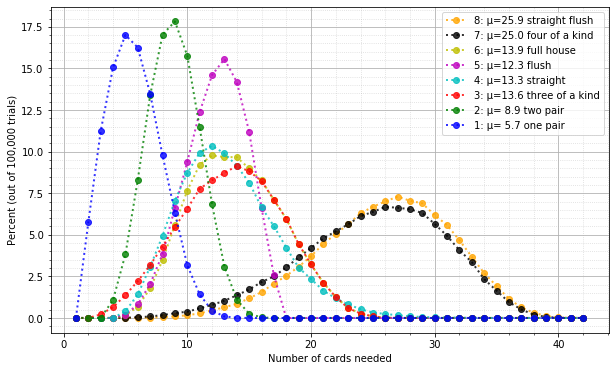

In [60]:
plot_what_firsts(counters)

OK, that looks kind of like a side view of the rollercoasters at Six Flags amusement park. Let's see if we can make sense of it. There seem to be three distinct patterns. First, there are three hand types with an early sharp peak: 

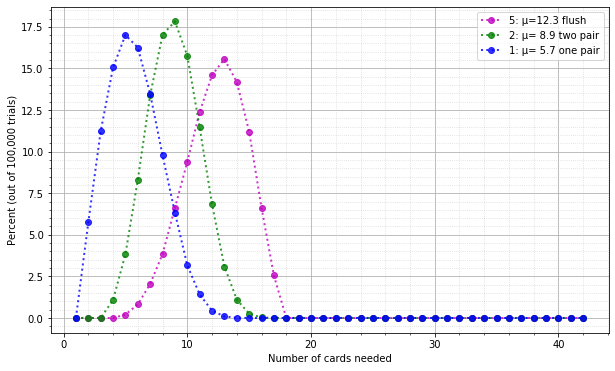

In [61]:
plot_what_firsts(counters, types=(1, 2, 5))

As discussed, the flush can go no more than 17 cards. Also by the pigeonhole principle, the pair can go no more than 14 cards (one card in each of the 13 ranks, and then the 14th card must form a pair) and two pair can go no more than 17 cards (one card in each of the 13 ranks, then 3 more cards in one of the ranks (making four of a kind), and then the 17th card must make a second pair).

Next are three tightly-grouped Gaussian-looking curves. It makes sense that three of a kind and full house are close together, because usually when you get three of a kind, you have gotten some other pair previously. I'm not sure why straight is so close to them.

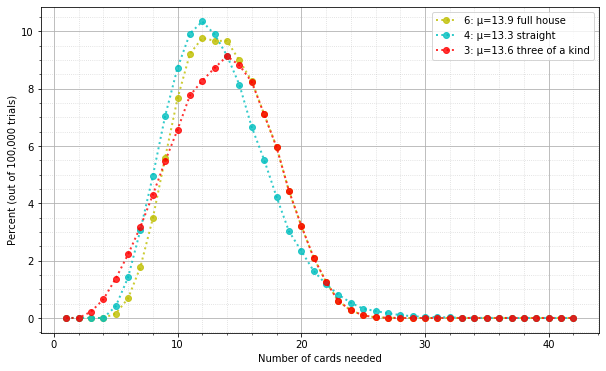

In [62]:
plot_what_firsts(counters, types=(3, 4, 6))

Finally, I was quite surprised to see how closely the straight flush and four of a kind curves track each other; I can't explain why:

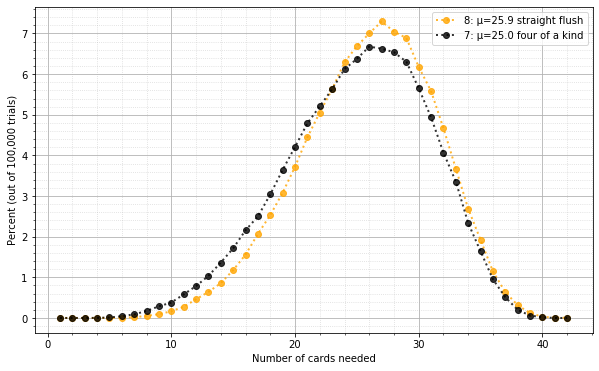

In [63]:
plot_what_firsts(counters, types=(7, 8))

That concludes our exploration of poker ranking; I hope it has inspired you to explore some on your own.